In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, LSTM, MaxPooling1D
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from keras import metrics

Using TensorFlow backend.


In [2]:
raw_data = pkl.load(open("gdr_assignment_labelled.pkl","rb"))

## un-list the label column

raw_data['label'] = raw_data['label'].apply(lambda x: x[0])
raw_data.sample(7)

,label,pp_sent
52599,Job Security/Advancement,good opportunities for career growth
69969,tech_product,no ego problem solving is mandatory across the...
101786,tech_product,schibsted has a broad tech stack
6968,culture_team,a self starter
1393294,haras_discrim_sexism,a great deal of effort has gone into gender di...
48187,wlb_working_conditions,work life balance is generally good
86026,tech_product,type of problems to be solved are unlike anyth...


(8000, 2)
Job Security/Advancement       1113
management                     1039
salary_benefits                1018
culture_team                   1010
haras_discrim_sexism           1001
wlb_working_conditions          997
tech_product                    983
business_vision_competitors     839
Name: label, dtype: int64


Text(0.5,1,'Distribution of label class in raw dataset')

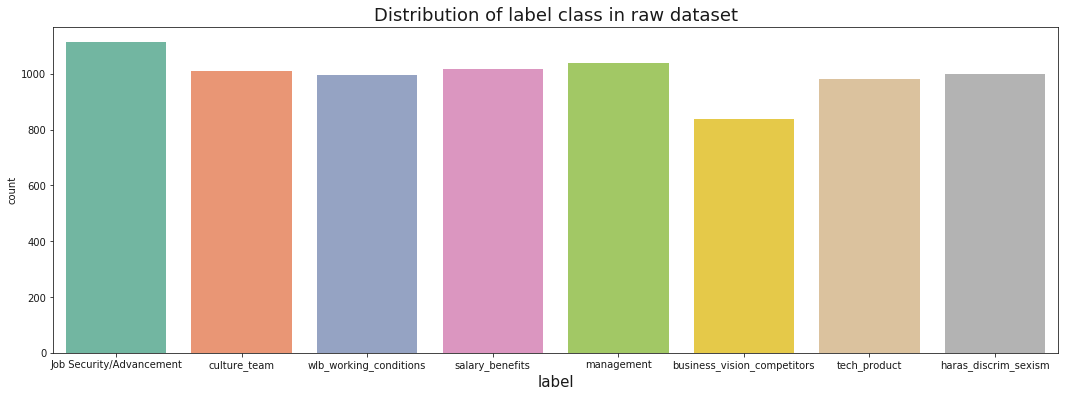

In [3]:
## shape of training data
print(raw_data.shape)

## count of labels in dataset

print(raw_data['label'].value_counts())

### distribution of labels in training set

sns.set_color_codes()

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('label', data = raw_data,palette="Set2", ax = ax1)
ax1.set_xlabel("label", size = 15)
plt.title("Distribution of label class in raw dataset", size = 18)

In [4]:
## check max length of sequence in pp_sent
print(max(raw_data['pp_sent'].apply(lambda x: len(x.split()))))

44


## Pre- process data

- convert labels to one-hot vectors
- convert pp_sent to numerical form and pad sequences

In [3]:
## process labels- label encoding
le = LabelEncoder()
labels_int = le.fit_transform(raw_data['label'].values)
labels = to_categorical(labels_int)

### prepare tokenizer

t = Tokenizer()
t.fit_on_texts(raw_data['pp_sent'].values)
vocab_size = len(t.word_index) + 1
print("vocab size:",vocab_size)

# integer encode the documents
encoded_docs = t.texts_to_sequences(raw_data['pp_sent'].values)
# pad documents to a max length of 44 words
max_length = 44
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print("padded_docs:",len(padded_docs))

vocab size: 3797
padded_docs: 8000


## Model 1- sequential model with convolution

- Here we also learn embedding layer weights based on training data
- Multi- class classification with 8 categories

In [14]:
model1 = Sequential()
model1.add(Embedding(vocab_size,10,input_length=max_length))
model1.add(Dropout(0.2))
model1.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(256))
model1.add(Dropout(0.2))
model1.add(Activation('relu'))
model1.add(Dense(8))
model1.add(Activation('softmax'))
print(model1.summary())
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

#train -test split- split into 80% for train and 20% for test
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.20,
                                                    random_state=5678, stratify =labels)

# fit the model
model1.fit(X_train, y_train, epochs=50,batch_size = 10,validation_data=(X_test,y_test))

# loss1, accuracy1 = model1.evaluate(padded_docs,labels, verbose=0)
# print("Accuracy:", accuracy1*100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 44, 10)            37970     
_________________________________________________________________
dropout_13 (Dropout)         (None, 44, 10)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 42, 64)            1984      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
__________

## Model2 -  Using pre trained- Glove 50- D word embeddings

In [7]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded {0} word vectors.'.format(len(embeddings_index)))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Loaded 400000 word vectors.
(3797, 50)


In [13]:
# define sequential CNN model
model2 = Sequential()
e = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length, trainable=False)
model2.add(e)
model2.add(Dropout(0.2))
model2.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(256))
model2.add(Dropout(0.2))
model2.add(Activation('relu'))
model2.add(Dense(8))
model2.add(Activation('softmax'))
# compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model2.summary())

#train -test split- split into 80% for train and 20% for test
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.20,
                                                    random_state=5678, stratify =labels)
# create model

# fit the model
model2.fit(X_train, y_train, epochs=50,batch_size = 10,validation_data=(X_test,y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 44, 50)            189850    
_________________________________________________________________
dropout_11 (Dropout)         (None, 44, 50)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 42, 64)            9664      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
__________

## Model 3- LSTM with convolution
- Hyperparameter Tuning - - Using Grid search CV
- stratified K fold

In [4]:
# Function to create model, required for KerasClassifier
def create_model(optimizer = "Adam"):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,10,input_length=max_length))
    model3.add(Dropout(0.2))
    model3.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))
    model3.add(MaxPooling1D(pool_size =2, strides =1))
    model3.add(LSTM(100,return_sequences=True))
    model3.add(Flatten())
    model3.add(Dropout(0.2))
    model3.add(Dense(256, activation = 'relu'))
    model3.add(Dropout(0.2))
    model3.add(Dense(8, activation = 'softmax'))
    # compile the model
#     optimizer = optimizer(lr = learn_rate)
    model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    return model3

##### Tuning optimizer, batch size, epochs, learning rate

In [5]:
# call model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10,20]
epochs = [10,30]
optimizer = ['SGD', 'Adam']

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer = optimizer)

# evaluate using 3-fold stratified cross validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1 )
grid_result = grid.fit(padded_docs, labels)

In [6]:
# summarize results

print("Best: {0} using {1} \n\n".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{0} ({1}) with: {2}".format(mean, stdev, param))

Best: 0.26687499888427557 using {'batch_size': 10, 'epochs': 10, 'optimizer': 'Adam'} 


0.022125000355765225 (0.02148269431754405) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'SGD'}
0.26687499888427557 (0.03502305082875849) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'Adam'}
0.1617500007636845 (0.016737052708153538) with: {'batch_size': 10, 'epochs': 30, 'optimizer': 'SGD'}
0.2581249985676259 (0.03038302724473645) with: {'batch_size': 10, 'epochs': 30, 'optimizer': 'Adam'}
0.0015000000223517418 (0.0021211215169199705) with: {'batch_size': 20, 'epochs': 10, 'optimizer': 'SGD'}
0.2481249985396862 (0.013569146204529531) with: {'batch_size': 20, 'epochs': 10, 'optimizer': 'Adam'}
0.0655000000409782 (0.07949717278247921) with: {'batch_size': 20, 'epochs': 30, 'optimizer': 'SGD'}
0.254749998992309 (0.01773504950114837) with: {'batch_size': 20, 'epochs': 30, 'optimizer': 'Adam'}
